In [125]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

# 1. Data
- 일반적인 Latent Model들이 아이템과 사용자의 정보를 복합적으로 이용하는 것과 다르게 AutoRec는 아이템, 사용자 중 하나에 대한 임베딩만을 진행한다.
- 아이템을 임베딩하는 Item-based 구조를 I-AutoRec, 사용자를 임베딩하는 User-based 구조를 U-AutoRec으로 명명한다. 해당의 예제에서는 Item-based 구조인 I-AutoRec을 기준으로 진행된다.

In [127]:
datas = pd.read_csv("datas/movielens_small/ratings.csv")
num_user = datas['userId'].unique().size
num_item = datas['movieId'].unique().size

print("사용자 수 : {} 명".format(num_user))
print("아이템 수 : {} 개".format(num_item))
datas.head()

사용자 수 : 671 명
아이템 수 : 9066 개


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [128]:
# User-based Data Setting Example
# user_df = datas.pivot_table("rating", index="userId", columns="movieId")

# Item-based Data Structure
item_df = datas.pivot_table("rating", index="movieId", columns="userId")
item_df.fillna(0, inplace=True)

print("item-based data shape : {}".format(item_df.shape))
item_df.head()

item-based data shape : (9066, 671)


userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
# data split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(item_df, test_size=0.1)
num_features = num_user

print("num features (item은 user가 feature 갯수, user는 item이 features 갯수) : {}".format(num_features))
print("train dataset shape : {}".format(train_df.shape))
print("test dataset shape : {}".format(test_df.shape))

num features (item은 user가 feature 갯수, user는 item이 features 갯수) : 671
train dataset shape : (8159, 671)
test dataset shape : (907, 671)


# 2. AutoRec

## 1. AutoRec Process

In [130]:
# 1. setting value
layers = [300, 100, 300]
reg = 0.01

num_layers = len(layers)
num_neuron = layers

In [131]:
# 2. setting layers
layers_list = []

for index in range(num_layers):
    layer = keras.layers.Dense(
                    num_neuron[index],
                    kernel_regularizer=keras.regularizers.l2(reg),
                    activation='relu',
                    name='layer{}'.format(index)
                )
    layers_list.append(layer)

output_layer = keras.layers.Dense(
                    num_features,
                    kernel_regularizer=keras.regularizers.l2(reg)
                )
layers_list.append(output_layer)

In [132]:
# 3. model setting
model = keras.models.Sequential()

for layer in layers_list:
    model.add(layer)

In [133]:
# 4. predict, keras.Model call
# def predict(inputs):
#     result = inputs
#     for layer in layers_list:
#         result = layer(result)
#     return result

# 같은의미
def predict(inputs):
    return model(inputs)

In [134]:
# 4. loss function
def MaskedMSELoss(y_true, y_pred):
    mask = y_true != 0
    
    # mask : 관측 데이터에는 1, 관측 되지 않은 데이터는 0
    mask_float = tf.cast(mask, tf.float32)
    masked_error = tf.reduce_mean(tf.pow(tf.subtract(mask_float * y_pred, y_true), 2))
    
    return masked_error

In [135]:
# 5. set optimizer, and metrics
learner = "SGD"
learning_rate = 0.01

if learner == "adagrad":
    optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
elif learner == "rmsprop":
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
elif learner == "adam":
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
else:
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    
metrics = [keras.metrics.RootMeanSquaredError()]

step : 1/20 ; loss : 0.1579381823539734
step : 2/20 ; loss : 0.15789760649204254
step : 3/20 ; loss : 0.15785710513591766
step : 4/20 ; loss : 0.15781667828559875
step : 5/20 ; loss : 0.157776340842247
step : 6/20 ; loss : 0.15773600339889526
step : 7/20 ; loss : 0.1576956957578659
step : 8/20 ; loss : 0.15765537321567535
step : 9/20 ; loss : 0.15761496126651764
step : 10/20 ; loss : 0.15757456421852112
step : 11/20 ; loss : 0.15753419697284698
step : 12/20 ; loss : 0.15749382972717285
step : 13/20 ; loss : 0.1574534922838211
step : 14/20 ; loss : 0.15741316974163055
step : 15/20 ; loss : 0.1573728621006012
step : 16/20 ; loss : 0.15733253955841064
step : 17/20 ; loss : 0.1572922319173813
step : 18/20 ; loss : 0.15725189447402954
step : 19/20 ; loss : 0.15721164643764496
step : 20/20 ; loss : 0.15717145800590515


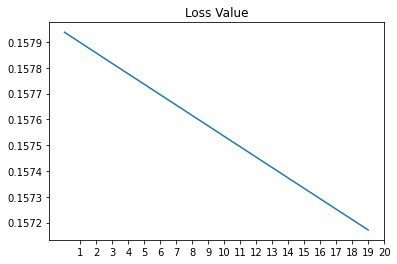

In [139]:
# 6. Train
batch_size = 32
X_batch = train_df.to_numpy()[:batch_size]
X_test = test_df.to_numpy()
steps = 20
loss_memory = []

for step in range(steps):
    with tf.GradientTape() as tape:
        _predict = predict(X_batch)
        loss_value = MaskedMSELoss(X_batch, _predict)
        loss_memory.append(loss_value)
    print("step : {}/{} ; loss : {}".format(step + 1,steps,loss_value))
    gradients = tape.gradient(loss_value, 
                  model.trainable_variables,
                  unconnected_gradients=tf.UnconnectedGradients.ZERO)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

plt.plot(loss_memory)
plt.xticks(range(1, 21))
plt.title("Loss Value")

plt.show()

# 2. Use

In [165]:
# 1. model setting
from model import AutoRec
model = AutoRec(num_features, reg=reg, layers=layers)

In [166]:
# 2. Callbacks
early_stop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# model_out_file = 'Pretrain/GMF_%s.h5' % (datetime.now().strftime('%Y-%m-%d-%h-%m-%s'))
# model_check_cb = keras.callbacks.ModelCheckpoint(model_out_file, save_best_only=True)

In [167]:
# 3. loss function
def MaskedMSELoss(y_true, y_pred):
    mask = y_true != 0
    
    # mask : 관측 데이터에는 1, 관측 되지 않은 데이터는 0
    mask_float = tf.cast(mask, tf.float32)
    masked_error = tf.reduce_mean(tf.pow(tf.subtract(mask_float * y_pred, y_true), 2))
    
    return masked_error

In [168]:
# 4. set optimizer, and metrics, model complie
learner = "SGD"
learning_rate = 0.01

if learner == "adagrad":
    optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
elif learner == "rmsprop":
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
elif learner == "adam":
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
else:
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    
metrics = [keras.metrics.RootMeanSquaredError()]

model.compile(optimizer=optimizer, loss=MaskedMSELoss, metrics=metrics)

In [169]:
# 5. Train
epochs = 10
batch_size=32

history = model.fit(train_df, train_df, batch_size=batch_size, epochs=epochs,
                   validation_data=(test_df, test_df), callbacks=[early_stop_cb])

Epoch 1/10
255/255 [==============================] - 3s 9ms/step - loss: 10.9693 - root_mean_squared_error: 0.4845 - val_loss: 10.4156 - val_root_mean_squared_error: 0.4686
Epoch 2/10
255/255 [==============================] - 2s 9ms/step - loss: 9.9247 - root_mean_squared_error: 0.4783 - val_loss: 9.4244 - val_root_mean_squared_error: 0.4639
Epoch 3/10
255/255 [==============================] - 3s 10ms/step - loss: 8.9825 - root_mean_squared_error: 0.4744 - val_loss: 8.5301 - val_root_mean_squared_error: 0.4608
Epoch 4/10
255/255 [==============================] - 3s 11ms/step - loss: 8.1322 - root_mean_squared_error: 0.4715 - val_loss: 7.7228 - val_root_mean_squared_error: 0.4584
Epoch 5/10
255/255 [==============================] - 3s 10ms/step - loss: 7.3646 - root_mean_squared_error: 0.4693 - val_loss: 6.9940 - val_root_mean_squared_error: 0.4564
Epoch 6/10
255/255 [==============================] - 2s 10ms/step - loss: 6.6715 - root_mean_squared_error: 0.4674 - val_loss: 6.3359 

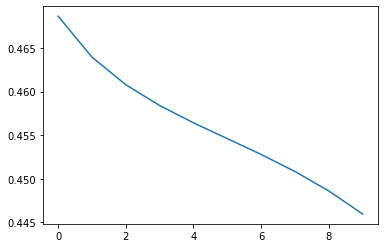

In [170]:
# 6. Result
plt.plot(history.history["val_root_mean_squared_error"])
plt.show()